# Text classification with BERT

This notebook briefly demonstrates text classification with a pretrained BERT model.

## Configuration

The following variables configure a few aspects of the data, model, and training process. To adapt this example to a different dataset, you'll probably want to change these to match.

Note in particular that we're limiting the number of examples to just 1000 out of the original 25000 to make training faster.

In [122]:
# Maximum number of examples to read
MAX_EXAMPLES = 1000

# Maximum length of input sequence in tokens
INPUT_LENGTH = 100

# Number of epochs to train for
EPOCHS = 3

# Training batch size
BATCH_SIZE = 4

## Package setup

We'll use [keras-bert](https://github.com/CyberZHG/keras-bert). Make sure the package is installed.

In [5]:
!pip3 install keras-bert

## Tensorflow configuration

(This is a technical detail that is not related to the model.)

In [6]:
import os


os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert

## Download dataset

We'll use the familiar IMDB dataset in JSON format.

In [7]:
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://raw.githubusercontent.com/TurkuNLP/Deep_Learning_in_LangTech_course/master/data/imdb_train.json

File ‘imdb_train.json’ already there; not retrieving.



## Load data

In [124]:
import json
import random


with open('imdb_train.json') as f:
    data = json.load(f)

random.seed(1234)    # This makes the shuffle produce the same order every time
random.shuffle(data)

if len(data) > MAX_EXAMPLES:
    print('Note: truncating examples from {} to {}'.format(len(data), MAX_EXAMPLES))
    data = data[:MAX_EXAMPLES]

# Look at the data
print(type(data))
print(type(data[0]))
print(data[0].keys())
print(data[0])

Note: truncating examples from 25000 to 1000
<class 'list'>
<class 'dict'>
dict_keys(['class', 'text'])
{'class': 'pos', 'text': "I saw Insomniac's Nightmare not to long ago for the first time and I have to say, I really found it to be quite good. If you are a fan of Dominic Monaghan you will love it. The hole movie takes place inside his mind -or does it? The acting from everyone else is a little rushed and shaky and some of the scenes could be cut down but it works out in the end. The extras on the DVD are just as great as the film, if not greater for those Dom fans. It has tons of candid moments from the set, outtakes and a great interview with the director. Anyone who has gone through making an independent film will love to watch Tess (the director), Dom and everyone else on the very small close personal set try to bang out this little trippy creepy film. It was pretty enjoyable and I'm glad to have it in my collection."}


In [14]:
texts = [example['text'] for example in data]
labels = [example['class'] for example in data]

# Example text and label
print('Text:', texts[0])
print('Label:', labels[0])

Text: I saw Insomniac's Nightmare not to long ago for the first time and I have to say, I really found it to be quite good. If you are a fan of Dominic Monaghan you will love it. The hole movie takes place inside his mind -or does it? The acting from everyone else is a little rushed and shaky and some of the scenes could be cut down but it works out in the end. The extras on the DVD are just as great as the film, if not greater for those Dom fans. It has tons of candid moments from the set, outtakes and a great interview with the director. Anyone who has gone through making an independent film will love to watch Tess (the director), Dom and everyone else on the very small close personal set try to bang out this little trippy creepy film. It was pretty enjoyable and I'm glad to have it in my collection.
Label: pos


## Download pretrained BERT model

As training BERT from scratch generally takes days, we'll here load a pretrained model and fine-tune it for our task. URLs to download pre-trained models made available by Google are found at https://github.com/google-research/bert .

`cased_L-12_H-768_A-12` is a case-sensitive BERT "base" model for English: 12 layers, 768-dimensional hidden state, and 12 "heads" for multi-head attention.

In [15]:
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip

--2020-04-15 14:57:43--  https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.211.16
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.211.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404261442 (386M) [application/zip]
Saving to: ‘cased_L-12_H-768_A-12.zip’

cased_L-12_H-768_A- 100%[===================>] 385.53M  1.04MB/s    in 7m 24s  

2020-04-15 15:05:08 (889 KB/s) - ‘cased_L-12_H-768_A-12.zip’ saved [404261442/404261442]



Unpack the downloaded file:

In [16]:
# Give -n argument so that existing files aren't overwritten 
!unzip -n cased_L-12_H-768_A-12.zip

Archive:  cased_L-12_H-768_A-12.zip
   creating: cased_L-12_H-768_A-12/
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: cased_L-12_H-768_A-12/vocab.txt  
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: cased_L-12_H-768_A-12/bert_config.json  


There are three key parts to the package contents:

* `vocab.txt`: plain text file listing vocabulary items
* `bert_config.json`: model configuration in JSON format
* `bert_model.ckpt.*`: model checkpoint data with pre-trained weights in [Tensorflow checkpoint format](https://www.tensorflow.org/guide/checkpoint)

Take note of the path to these (you'll need to change this if you pick a different model)

In [17]:
bert_vocab_path = 'cased_L-12_H-768_A-12/vocab.txt'
bert_config_path = 'cased_L-12_H-768_A-12/bert_config.json'
bert_checkpoint_path = 'cased_L-12_H-768_A-12/bert_model.ckpt'    # suffixes not required

Also take note if the model we downloaded was a case-sensitive (cased) or not. (This must match the model.)

In [26]:
model_is_cased = True

## Load BERT vocabulary

This is just a plain text file with one vocabulary item per line.

In [27]:
vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))


# print a list with every 500th vocabulary item
print(vocab[0::500])

['[PAD]', 'щ', '吉', 'told', 'space', 'operations', 'proposed', 'Oxford', 'showing', 'domestic', 'mountains', 'commission', 'voices', 'associate', 'hills', 'Guide', 'relaxed', 'Page', 'Heights', 'singers', 'Interior', 'considers', 'facilitate', 'shouting', '1826', 'constitute', 'alter', 'clip', 'Into', 'Memory', 'ballad', 'Owens', 'Langdon', 'aquatic', 'stereo', 'Cass', 'Shock', '195', '##tec', '##sonic', 'attested', '##rdes', '1840s', '##90', 'Guys', '##rien', 'Munro', 'Ursula', 'mesh', 'diplomacy', 'Newmarket', '##oughs', 'synthesizers', 'Drugs', 'monstrous', '##ynamic', 'troll', '##ٹ']


## Load BERT configuration

In [28]:
from pprint import pprint    # pretty-printer for output


with open(bert_config_path) as f:
    config = json.load(f)


# Print configuration contents
pprint(config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 28996}


## Create BERT tokenizer

In [44]:
# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }


# Print some random examples of the mapping
pprint(dict(random.choices(list(token_dict.items()), k=10)))

{'##ein': 20309,
 '##nce': 3633,
 '2014': 1387,
 'Dennis': 6277,
 'Jam': 13263,
 'coffin': 16638,
 'dense': 9613,
 'frequencies': 13714,
 'recovering': 14299,
 'れ': 929}


We'll use the keras-bert `Tokenizer` for BERT tokenization. The implementation supports

* (Optional) lowercasing: `Hello` → `hello`
* Basic tokenization: `Hello!` → `Hello` `!`, `multi-part` → `multi` `-` `part`
* Wordpiece tokenization: `comprehensively` → `comprehensive` `##ly`
* Adding special tokens: `Sentence`  → `[CLS]` `Sentence` `[SEP]`
* Mapping to integer indices
* Generating segment sequence
* (Optional) padding and truncation to length

In [84]:
from keras_bert import Tokenizer


tokenizer = Tokenizer(token_dict, cased=model_is_cased)


# Let's test that out
for s in ['Hello BERT!', 'Unknown: 你']:
    print('Original string:', s)
    print('Tokenized:', tokenizer.tokenize(s))
    indices, segments = tokenizer.encode(s, max_len=20)    # max_len for padding and truncation
    print('Encoded:', indices)
    print('Segments:', segments)
    print('Decoded:', ' '.join(tokenizer.decode(indices)))
    print()

Original string: Hello BERT!
Tokenized: ['[CLS]', 'Hello', 'B', '##ER', '##T', '!', '[SEP]']
Encoded: [101, 8667, 139, 9637, 1942, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Hello B ##ER ##T !

Original string: Unknown: 你
Tokenized: ['[CLS]', 'Unknown', ':', '你', '[SEP]']
Encoded: [101, 16285, 131, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Unknown : [UNK]



## Vectorize data

We'll use the familiar `LabelEncoder` for labels and the keras-bert `Tokenizer` for text data.

In [87]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()    # Turns class labels into integers
Y = label_encoder.fit_transform(labels)

# Take note of how many unique labels there are in the data
num_labels = len(set(Y))


# Print out some examples
print('Number of unique labels:', num_labels)
print(type(labels), labels[:10])
print(type(Y), Y[:10])

Number of unique labels: 2
<class 'list'> ['pos', 'neg', 'pos', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'pos']
<class 'numpy.ndarray'> [1 0 1 1 1 0 0 1 0 1]


Keep token indices and segment ids in separate lists and store as numpy arrays:

In [98]:
import numpy as np


token_indices, segment_ids = [], []
for text in texts:
    tid, sid = tokenizer.encode(text, max_len=INPUT_LENGTH)
    token_indices.append(tid)
    segment_ids.append(sid)

# Format input as list of two numpy arrays
X = [np.array(token_indices), np.array(segment_ids)]


# Print some examples
print('Token indices:')
print(X[0][:2])
print('Decoded:')
for i in X[0][:2]:
    print(tokenizer.decode(list(i)))
print('Segment ids:')
print(X[1][:2])

Token indices:
[[  101   146  1486  1130  7301  1306  5813  1665   112   188 26247  1136
   1106  1263  2403  1111  1103  1148  1159  1105   146  1138  1106  1474
    117   146  1541  1276  1122  1106  1129  2385  1363   119  1409  1128
   1132   170  5442  1104 11288 15706 23136  1128  1209  1567  1122   119
   1109  4569  2523  2274  1282  1656  1117  1713   118  1137  1674  1122
    136  1109  3176  1121  2490  1950  1110   170  1376  6169  1105 16591
   1105  1199  1104  1103  4429  1180  1129  2195  1205  1133  1122  1759
   1149  1107  1103  1322   119  1109  3908  1116  1113  1103  4173  1132
   1198  1112  1632   102]
 [  101  1109  1273  1110   170  2436  1104   172 26567   112   188  1113
   1198  1164  1625  1149  1175   119  1135  1144  1185  2817 20748   117
   1185  2513   117  1185  1842  3802   119   156 17162 15792  1863  1110
   2873  1166  1103  1499  1105 17000  2340  2624  1110 13504  1105 22052
   2285   119  1188  2523  1169   112   189  9345  1103 23483  1104  1

## Load pretrained BERT model

We'll use the keras-bert function `load_trained_model_from_checkpoint` to load the model from the checkpoint we downloaded earlier.

Explanation for a few parameters from keras-bert documentation:

* `training`: If `training`, the whole model will be returned. Otherwise, the MLM [masked language modeling] and NSP [next sentence prediction] parts will be ignored.
* `trainable`: Whether the model is trainable. The default value is the same with `training`.

We don't need the masked language modeling or next sentence prediction parts (these are primarily for pretraining), so we'll use `training=False` but `trainable=True`.

In [106]:
from keras_bert import load_trained_model_from_checkpoint


pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False,
    trainable = True,
    seq_len = INPUT_LENGTH
)

Let's have a bit of a look at that model

In [107]:
pretrained_model.inputs

[<tf.Tensor 'Input-Token_4:0' shape=(?, 100) dtype=float32>,
 <tf.Tensor 'Input-Segment_4:0' shape=(?, 100) dtype=float32>]

In [108]:
pretrained_model.outputs

[<tf.Tensor 'Encoder-12-FeedForward-Norm_4/add_1:0' shape=(?, 100, 768) dtype=float32>]

In [109]:
pretrained_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 100)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 100, 768), ( 22268928    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 100, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

                                                                 Encoder-10-FeedForward-Dropout[0]
__________________________________________________________________________________________________
Encoder-10-FeedForward-Norm (La (None, 100, 768)     1536        Encoder-10-FeedForward-Add[0][0] 
__________________________________________________________________________________________________
Encoder-11-MultiHeadSelfAttenti (None, 100, 768)     2362368     Encoder-10-FeedForward-Norm[0][0]
__________________________________________________________________________________________________
Encoder-11-MultiHeadSelfAttenti (None, 100, 768)     0           Encoder-11-MultiHeadSelfAttention
__________________________________________________________________________________________________
Encoder-11-MultiHeadSelfAttenti (None, 100, 768)     0           Encoder-10-FeedForward-Norm[0][0]
                                                                 Encoder-11-MultiHeadSelfAttention
__________

This is a regular Keras model. In Keras, models behave very much like layers, so we're able to wrap this in our own model.

## Build classification model

We'll make a *very* simple model for text classification: just attach a dense layer to the output for the special `[CLS]` token, and connect the model inputs to the BERT model inputs.

First, let's find the output

In [110]:
print(pretrained_model.outputs)

[<tf.Tensor 'Encoder-12-FeedForward-Norm_4/add_1:0' shape=(?, 100, 768) dtype=float32>]


Those dimensions are (minibatch-size, sequence-length, hidden-dim).

We'll just need the first sequence position across all elements in the initial (minibatch) dimension:

In [125]:
bert_out = pretrained_model.outputs[0][:,0]

print(bert_out)

Tensor("strided_slice_4:0", shape=(?, 768), dtype=float32)


In [116]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense


out = Dense(num_labels, activation='softmax')(bert_out)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

## Create optimizer

BERT is pretrained with an Adam optimizer with warmup and regularization using weight decay. We won't go into detail on these optimizer settings, but will instead largely copy the BERT pretraining parameters.

(If you're interested in tuning the training process, trying different values of `learning_rate` is a good place to start!)

In [118]:
from keras_bert import calc_train_steps, AdamWarmup


# Learning rate setting
learning_rate = 0.00005

# Calculate the number of steps for warmup
total_steps, warmup_steps = calc_train_steps(
    num_example=len(texts),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=learning_rate,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

## Train model

The model is compiled and trained normally. As usual, we'll use `sparse_categorical_crossentropy` loss.

In [120]:
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

(Note: this will take some time unless you're running with GPU acceleration.)

In [121]:
history = model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 900 samples, validate on 100 samples
Epoch 1/3
900/900 [==============================] - 1261s 1s/sample - loss: 0.6622 - sparse_categorical_accuracy: 0.6478 - val_loss: 0.7608 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/3
900/900 [==============================] - 1178s 1s/sample - loss: 0.3537 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.3066 - val_sparse_categorical_accuracy: 0.8900
Epoch 3/3
900/900 [==============================] - 1181s 1s/sample - loss: 0.0666 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.4433 - val_sparse_categorical_accuracy: 0.8500


Let's plot that

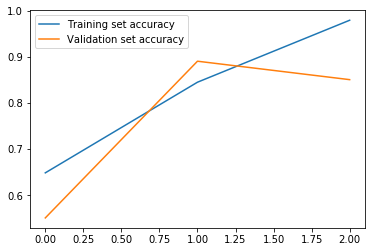

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(history):
    plt.plot(history.history['sparse_categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_sparse_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()


plot_history(history)

This is definitely overfit by the end of the third epoch; training set accuracy goes to 98%. The best dev set result is for the second epoch, at 89%. Not a bad result for such a small sample of the data!